# <strong>Stock Prediction Analysis using Regression-Enhanced Random Forest (REFR)<strong>

This notebook aims to analyse the prediction abilities of the Regression-Enhanced Random Forest model by H Zhang, D Nettleton and Z Zhu 
<br>Paper: https://arxiv.org/pdf/1904.10416.pdf<br>
    
The model will be used to predict Pepsi Stock (PEP), and will be compared against technical analysis based trading (SMA crossover) and simple machine learning (LASSO Regression) to test its effectiveness.

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
#getting API key from alphavantage to retrieve stock price data in .json format
apikey = "F949052R9IWU75A8"
time_series = "TIME_SERIES_DAILY_ADJUSTED"
ticker = "PEP"

output_size = "full"

data = requests.get(f"https://www.alphavantage.co/query?function={time_series}&symbol={ticker}&outputsize={output_size}&apikey={apikey}")

series = data.json()

In [3]:
print(len(data.json()))

2


In [4]:
#creating and cleaning base dataframe
df_prep = pd.DataFrame(series["Time Series (Daily)"]).T
df = df_prep.drop(["5. adjusted close","7. dividend amount","8. split coefficient"] , axis = 1)
df

,1. open,2. high,3. low,4. close,6. volume
2022-12-23,180.91,182.55,180.45,182.26,2197807
2022-12-22,181.86,182.05,178.9166,181.09,4305729
2022-12-21,181.55,183.68,181.4,182.5,4237039
2022-12-20,181.815,182.25,180.64,181.23,3249006
2022-12-19,180.86,183.47,180.35,181.34,4447962
...,...,...,...,...,...
1999-11-05,33.0,34.06,33.0,33.81,4080100
1999-11-04,34.25,34.56,32.06,33.0,4683900
1999-11-03,33.81,34.31,33.75,34.25,2898500
1999-11-02,33.63,34.31,33.56,33.69,2682900


In [5]:
df.index = pd.to_datetime(df.index)
df_data = df.astype(float).sort_index(ascending = True)
print(type(df.index))
print(df.isnull().sum())
print(df.shape)
print(type(df))
df_data

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
1. open      0
2. high      0
3. low       0
4. close     0
6. volume    0
dtype: int64
(5826, 5)
<class 'pandas.core.frame.DataFrame'>


,1. open,2. high,3. low,4. close,6. volume
1999-11-01,34.440,34.56,33.5600,33.56,3635000.0
1999-11-02,33.630,34.31,33.5600,33.69,2682900.0
1999-11-03,33.810,34.31,33.7500,34.25,2898500.0
1999-11-04,34.250,34.56,32.0600,33.00,4683900.0
1999-11-05,33.000,34.06,33.0000,33.81,4080100.0
...,...,...,...,...,...
2022-12-19,180.860,183.47,180.3500,181.34,4447962.0
2022-12-20,181.815,182.25,180.6400,181.23,3249006.0
2022-12-21,181.550,183.68,181.4000,182.50,4237039.0
2022-12-22,181.860,182.05,178.9166,181.09,4305729.0


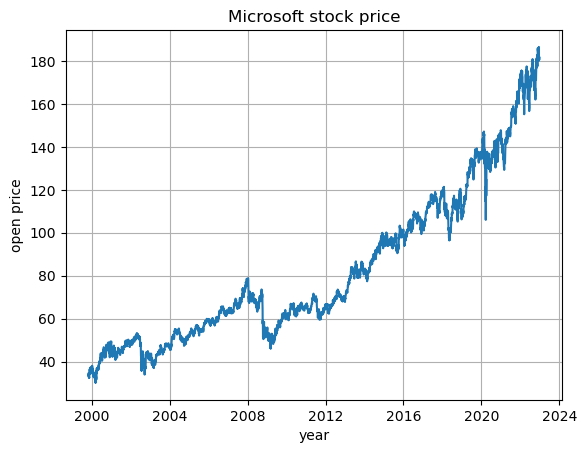

In [6]:
fig, ax = plt.subplots()
ax.plot(df_data.index, df_data['1. open'])
ax.set(xlabel='year', ylabel='open price',
       title='Microsoft stock price')
ax.grid()
plt.show()

# <strong>Preparing data for technical analysis<strong>

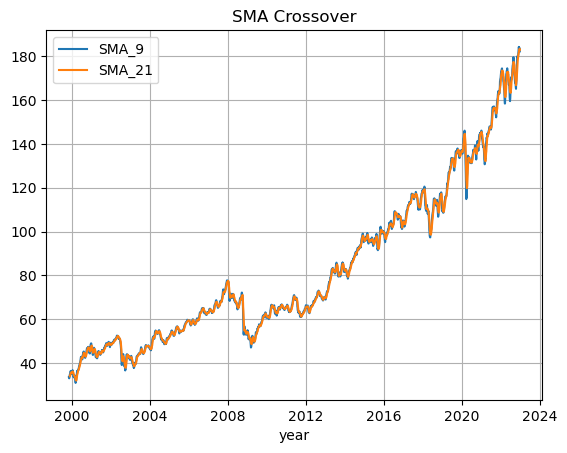

In [7]:
#adding 9 and 21 day SMA data

df_data['SMA_9'] = df_data['1. open'].rolling(9).mean()
df_data['SMA_21'] = df_data['1. open'].rolling(21).mean()

fig, ax = plt.subplots()
ax.plot(df_data.index, df_data['SMA_9'], label = 'SMA_9')
ax.plot(df_data.index, df_data['SMA_21'], label = 'SMA_21')
ax.set(xlabel='year', ylabel='',
       title='SMA Crossover')
plt.legend(loc = 'upper left')
ax.grid()
plt.show()

In [8]:
#split data into pre and post covid dates, to analyse prediction performance pre and post covid for time periods of equal lengths
df_pre_all = df_data.loc[df_data.index < "2020-02-19"]
df_post = df_data.loc[df_data.index > "2020-06-20"] 
df_pre = df_pre_all.tail(int(len(df_post)))

display(df_pre)
display(df_post)

,1. open,2. high,3. low,4. close,6. volume,SMA_9,SMA_21
2017-08-10,116.35,116.8400,116.080,116.38,2141060.0,116.343333,116.013810
2017-08-11,116.75,117.2500,116.350,116.51,2759732.0,116.367778,116.099524
2017-08-14,117.36,118.1800,117.014,117.84,3171266.0,116.442222,116.247143
2017-08-15,117.88,119.1500,117.850,118.97,2684126.0,116.681111,116.387143
2017-08-16,118.96,119.3645,118.820,119.10,2324489.0,117.040000,116.582857
...,...,...,...,...,...,...,...
2020-02-11,146.21,146.3600,144.870,146.08,3870894.0,144.091111,141.869524
2020-02-12,146.68,146.7400,145.350,146.08,4217415.0,144.575556,142.442381
2020-02-13,145.25,147.1300,143.520,146.47,5041366.0,144.735556,142.874286
2020-02-14,146.57,147.1500,145.940,146.99,3555977.0,145.157778,143.328095


,1. open,2. high,3. low,4. close,6. volume,SMA_9,SMA_21
2020-06-22,130.550,131.76,129.9500,131.05,3379894.0,131.765556,131.622381
2020-06-23,131.620,132.68,130.9800,131.36,3625580.0,131.581111,131.718095
2020-06-24,130.520,131.07,128.6800,129.56,4853490.0,131.170000,131.650476
2020-06-25,129.140,131.73,128.0500,131.41,4442112.0,131.168889,131.622857
2020-06-26,131.680,132.37,128.0600,128.93,7372682.0,131.545556,131.645238
...,...,...,...,...,...,...,...
2022-12-19,180.860,183.47,180.3500,181.34,4447962.0,182.831111,183.314762
2022-12-20,181.815,182.25,180.6400,181.23,3249006.0,182.831667,183.391190
2022-12-21,181.550,183.68,181.4000,182.50,4237039.0,182.802778,183.356905
2022-12-22,181.860,182.05,178.9166,181.09,4305729.0,182.541667,183.168810


In [9]:
#SMA trading strategy will only be implemented on the last 8% of the datasets to compare agianst ML test sets

df_pre_test = df_pre.tail(int(0.08*(len(df_pre))))
df_post_test = df_post.tail(int(0.08*(len(df_post))))

# <strong>Implementing SMA crossover trading strategy (pre-Covid)<strong>

/var/folders/gl/_7vxdj795rgcq3s4lj00kbk80000gp/T/ipykernel_15505/1422092876.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre_test['portfolio_sma'] = portfolio_sma_pre
/var/folders/gl/_7vxdj795rgcq3s4lj00kbk80000gp/T/ipykernel_15505/1422092876.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre_test['cash_sma'] = cash_sma_pre
/var/folders/gl/_7vxdj795rgcq3s4lj00kbk80000gp/T/ipykernel_15505/1422092876.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

,1. open,2. high,3. low,4. close,6. volume,SMA_9,SMA_21,portfolio_sma,cash_sma,portfolio_value
2019-12-05,136.19,136.54,135.27,136.34,3351990.0,135.453333,134.441429,734,36.54,100000.00
2019-12-06,136.67,137.69,136.34,137.36,3216924.0,135.758889,134.544762,734,36.54,100352.32
2019-12-09,137.15,138.04,137.00,137.16,3927667.0,136.035556,134.675238,734,36.54,100704.64
2019-12-10,137.61,137.61,136.17,136.27,2940212.0,136.404444,134.880952,734,36.54,101042.28
2019-12-11,137.05,137.54,136.32,137.10,3339278.0,136.554444,135.072381,734,36.54,100631.24
2019-12-12,136.80,137.90,136.75,137.18,3502138.0,136.636667,135.268571,734,36.54,100447.74
2019-12-13,136.93,138.25,136.19,137.94,3558062.0,136.667778,135.473333,734,36.54,100543.16
2019-12-16,136.95,137.52,136.16,137.06,4701155.0,136.700000,135.632857,734,36.54,100557.84
2019-12-17,137.05,137.44,135.69,136.17,5491845.0,136.933333,135.794286,734,36.54,100631.24
2019-12-18,137.05,137.30,135.63,135.97,5370538.0,137.028889,135.939524,734,36.54,100631.24


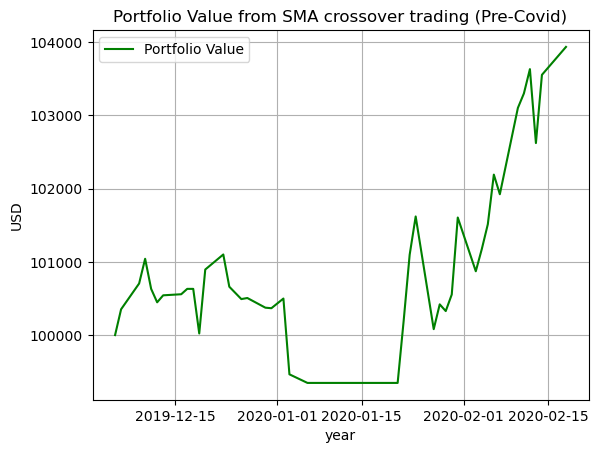

Total portfolio value: 103935.74


In [10]:
cash = 100000
shares = 0

portfolio_sma_pre = []
cash_sma_pre = []

for index, row in df_pre_test.iterrows():
    if row['SMA_9'] > row['SMA_21']: #buy signal
        if shares > 0: 
            #hold onto shares
            portfolio_sma_pre.append(shares)
            cash_sma_pre.append(cash)
        elif shares <= 0:
            #buy shares here
            shares = int((cash / row['1. open']))
            cash = (cash - (shares * row['1. open']))
            portfolio_sma_pre.append(shares)
            cash_sma_pre.append(cash)
            
    elif row['SMA_9'] < row['SMA_21']: # sell signal
        if shares <= 0:
            #hold onto cash
            portfolio_sma_pre.append(shares)
            cash_sma_pre.append(cash)
        elif shares > 0:
            #sell shares here
            cash = cash + (shares * row['1. open'])
            shares = 0
            portfolio_sma_pre.append(shares)
            cash_sma_pre.append(cash)
       
df_pre_test['portfolio_sma'] = portfolio_sma_pre
df_pre_test['cash_sma'] = cash_sma_pre
df_pre_test['portfolio_value'] = (df_pre_test['portfolio_sma'] * df_pre_test['1. open']) + df_pre_test['cash_sma']
display(df_pre_test)

fig, ax = plt.subplots()
ax.plot(df_pre_test.index, df_pre_test['portfolio_value'], '-g', label = 'Portfolio Value')
ax.set(xlabel='year', ylabel='USD',
       title='Portfolio Value from SMA crossover trading (Pre-Covid)')
plt.legend(loc = 'upper left')
ax.grid()
plt.show()

total_value_sma = df_pre_test.iloc[-1,9]
print("Total portfolio value: " + str((round(total_value_sma,2))))

# <strong>Implementing SMA crossover trading strategy (post-COVID)<strong>

/var/folders/gl/_7vxdj795rgcq3s4lj00kbk80000gp/T/ipykernel_15505/2539837762.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_post_test['portfolio_sma'] = portfolio_sma_post
/var/folders/gl/_7vxdj795rgcq3s4lj00kbk80000gp/T/ipykernel_15505/2539837762.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_post_test['cash_sma'] = cash_sma_post
/var/folders/gl/_7vxdj795rgcq3s4lj00kbk80000gp/T/ipykernel_15505/2539837762.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

,1. open,2. high,3. low,4. close,6. volume,SMA_9,SMA_21,portfolio_sma,cash_sma,portfolio_value
2022-10-14,175.980,176.2580,169.9900,170.19,5939034.0,166.498333,167.125952,0,100000.00,100000.00
2022-10-17,172.270,173.5900,171.0700,172.73,6401844.0,167.040556,167.407381,0,100000.00,100000.00
2022-10-18,174.820,176.9100,173.4100,175.06,4547398.0,167.912778,167.776905,572,2.96,100000.00
2022-10-19,174.820,175.8400,172.3300,173.36,5200248.0,168.916667,168.121667,572,2.96,100000.00
2022-10-20,174.200,174.3600,171.1100,171.46,4313954.0,170.238889,168.327381,572,2.96,99645.36
2022-10-21,171.200,173.6850,170.5800,173.06,5071500.0,171.262222,168.460714,572,2.96,97929.36
2022-10-24,174.810,177.9800,174.6700,177.68,5316608.0,172.658889,168.766429,572,2.96,99994.28
2022-10-25,178.120,178.8700,176.6100,178.27,5220027.0,173.702222,169.232619,572,2.96,101887.60
2022-10-26,179.260,180.9000,178.3200,179.07,5138962.0,175.053333,169.757381,572,2.96,102539.68
2022-10-27,180.370,180.9300,178.5700,178.88,5424089.0,175.541111,170.398333,572,2.96,103174.60


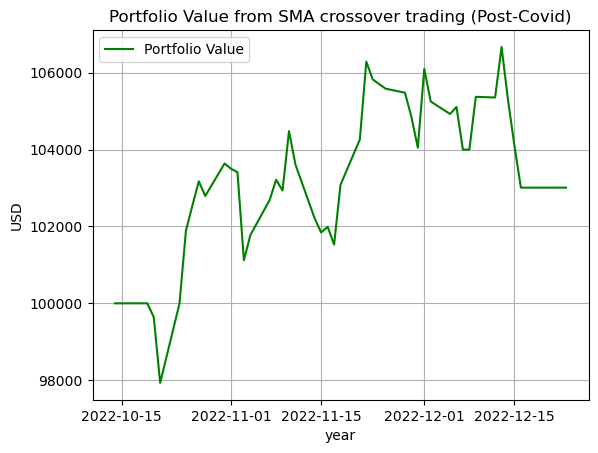

Total portfolio value: 103008.72


In [11]:
cash = 100000
shares = 0

portfolio_sma_post = []
cash_sma_post = []

for index, row in df_post_test.iterrows():
    if row['SMA_9'] > row['SMA_21']: #buy signal
        if shares > 0: 
            #hold onto shares
            portfolio_sma_post.append(shares)
            cash_sma_post.append(cash)
        elif shares <= 0:
            #buy shares here
            shares = int((cash / row['1. open']))
            cash = (cash - (shares * row['1. open']))
            portfolio_sma_post.append(shares)
            cash_sma_post.append(cash)
            
    elif row['SMA_9'] < row['SMA_21']: # sell signal
        if shares <= 0:
            #hold onto cash
            portfolio_sma_post.append(shares)
            cash_sma_post.append(cash)
        elif shares > 0:
            #sell shares here
            cash = cash + (shares * row['1. open'])
            shares = 0
            portfolio_sma_post.append(shares)
            cash_sma_post.append(cash)
       
df_post_test['portfolio_sma'] = portfolio_sma_post
df_post_test['cash_sma'] = cash_sma_post
df_post_test['portfolio_value'] = (df_post_test['portfolio_sma'] * df_post_test['1. open']) + df_post_test['cash_sma']
display(df_post_test)

fig, ax = plt.subplots()
ax.plot(df_post_test.index, df_post_test['portfolio_value'], '-g', label = 'Portfolio Value')
ax.set(xlabel='year', ylabel='USD',
       title='Portfolio Value from SMA crossover trading (Post-Covid)')
plt.legend(loc = 'upper left')
ax.grid()
plt.show()

total_value_sma_post = df_post_test.iloc[-1,9]
print("Total portfolio value: " + str((round(total_value_sma_post,2))))

# <strong>Preparing data for machine learning<strong>

In [12]:
df_dates_pre = df_pre.copy()
df_dates_pre["day_of_week"] = df_dates_pre.index.dayofweek
df_dates_pre["day_of_month"] = df_dates_pre.index.day
df_dates_pre["month"] = df_dates_pre.index.month

df_dates_post = df_post.copy()
df_dates_post["day_of_week"] = df_dates_post.index.dayofweek
df_dates_post["day_of_month"] = df_dates_post.index.day
df_dates_post["month"] = df_dates_post.index.month

display(df_dates_pre)
display(df_dates_post)

,1. open,2. high,3. low,4. close,6. volume,SMA_9,SMA_21,day_of_week,day_of_month,month
2017-08-10,116.35,116.8400,116.080,116.38,2141060.0,116.343333,116.013810,3,10,8
2017-08-11,116.75,117.2500,116.350,116.51,2759732.0,116.367778,116.099524,4,11,8
2017-08-14,117.36,118.1800,117.014,117.84,3171266.0,116.442222,116.247143,0,14,8
2017-08-15,117.88,119.1500,117.850,118.97,2684126.0,116.681111,116.387143,1,15,8
2017-08-16,118.96,119.3645,118.820,119.10,2324489.0,117.040000,116.582857,2,16,8
...,...,...,...,...,...,...,...,...,...,...
2020-02-11,146.21,146.3600,144.870,146.08,3870894.0,144.091111,141.869524,1,11,2
2020-02-12,146.68,146.7400,145.350,146.08,4217415.0,144.575556,142.442381,2,12,2
2020-02-13,145.25,147.1300,143.520,146.47,5041366.0,144.735556,142.874286,3,13,2
2020-02-14,146.57,147.1500,145.940,146.99,3555977.0,145.157778,143.328095,4,14,2


,1. open,2. high,3. low,4. close,6. volume,SMA_9,SMA_21,day_of_week,day_of_month,month
2020-06-22,130.550,131.76,129.9500,131.05,3379894.0,131.765556,131.622381,0,22,6
2020-06-23,131.620,132.68,130.9800,131.36,3625580.0,131.581111,131.718095,1,23,6
2020-06-24,130.520,131.07,128.6800,129.56,4853490.0,131.170000,131.650476,2,24,6
2020-06-25,129.140,131.73,128.0500,131.41,4442112.0,131.168889,131.622857,3,25,6
2020-06-26,131.680,132.37,128.0600,128.93,7372682.0,131.545556,131.645238,4,26,6
...,...,...,...,...,...,...,...,...,...,...
2022-12-19,180.860,183.47,180.3500,181.34,4447962.0,182.831111,183.314762,0,19,12
2022-12-20,181.815,182.25,180.6400,181.23,3249006.0,182.831667,183.391190,1,20,12
2022-12-21,181.550,183.68,181.4000,182.50,4237039.0,182.802778,183.356905,2,21,12
2022-12-22,181.860,182.05,178.9166,181.09,4305729.0,182.541667,183.168810,3,22,12


In [13]:
#creating dummies
dow_dum_pre = pd.get_dummies(df_dates_pre['day_of_week'], prefix='dow_')
dom_dum_pre = pd.get_dummies(df_dates_pre['day_of_month'], prefix='dom_')
month_dum_pre = pd.get_dummies(df_dates_pre['month'], prefix='month_')

df_dummy_pre = pd.concat([dow_dum_pre, dom_dum_pre, month_dum_pre], axis = 1)

dow_dum_post = pd.get_dummies(df_dates_post['day_of_week'], prefix='dow_')
dom_dum_post = pd.get_dummies(df_dates_post['day_of_month'], prefix='dom_')
month_dum_post = pd.get_dummies(df_dates_post['month'], prefix='month_')

df_dummy_post = pd.concat([dow_dum_post, dom_dum_post, month_dum_post], axis = 1)


In [14]:
#shifting open prices back by a day, to use close prices from past to predict future open prices
df_dates_pre['open_shift'] = df_dates_pre['1. open'].shift(-1)
df_dates_pre_drop = df_dates_pre.drop(columns=['1. open', '2. high','3. low','day_of_week', 'day_of_month', 'month', 'SMA_9', 'SMA_21'], axis = 1)
df_ml_pre = pd.concat([df_dates_pre_drop,df_dummy_pre], axis = 1)
display(df_ml_pre)

df_dates_post['open_shift'] = df_dates_post['1. open'].shift(-1)
df_dates_post_drop = df_dates_post.drop(columns=['1. open', '2. high','3. low','day_of_week', 'day_of_month', 'month', 'SMA_9', 'SMA_21'], axis = 1)
df_ml_post = pd.concat([df_dates_post_drop,df_dummy_post], axis = 1)
display(df_ml_post)

,4. close,6. volume,open_shift,dow__0,dow__1,dow__2,dow__3,dow__4,dom__1,dom__2,...,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12
2017-08-10,116.38,2141060.0,116.75,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2017-08-11,116.51,2759732.0,117.36,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2017-08-14,117.84,3171266.0,117.88,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2017-08-15,118.97,2684126.0,118.96,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2017-08-16,119.10,2324489.0,119.00,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-11,146.08,3870894.0,146.68,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-02-12,146.08,4217415.0,145.25,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-02-13,146.47,5041366.0,146.57,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-02-14,146.99,3555977.0,147.11,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


,4. close,6. volume,open_shift,dow__0,dow__1,dow__2,dow__3,dow__4,dom__1,dom__2,...,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12
2020-06-22,131.05,3379894.0,131.620,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2020-06-23,131.36,3625580.0,130.520,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2020-06-24,129.56,4853490.0,129.140,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2020-06-25,131.41,4442112.0,131.680,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2020-06-26,128.93,7372682.0,130.180,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-19,181.34,4447962.0,181.815,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2022-12-20,181.23,3249006.0,181.550,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2022-12-21,182.50,4237039.0,181.860,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2022-12-22,181.09,4305729.0,180.910,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# <strong>Creating train and test sets<strong>

In [15]:
x_pre = df_ml_pre.drop(['open_shift'], axis = 1)
y_pre = df_ml_pre['open_shift']

x_post = df_ml_post.drop(['open_shift'], axis = 1)
y_post = df_ml_post['open_shift']

In [16]:
# creating train and test sets for linear model, pre-covid
train_x_pre = x_pre.head(int(0.6*(len(x_pre))))
test_x_pre_na = x_pre.tail(int(0.4*(len(x_pre))))
test_x_pre = test_x_pre_na[:-1]

train_y_pre = y_pre.head(int(0.6*(len(y_pre))))
test_y_pre_na = y_pre.tail(int(0.4*(len(y_pre))))
test_y_pre = test_y_pre_na[:-1]

train_x_pre.shape,test_x_pre.shape,train_y_pre.shape,test_y_pre.shape

((380, 50), (252, 50), (380,), (252,))

In [17]:
# creating train and test sets for linear model, post-covid
train_x_post = x_post.head(int(0.6*(len(x_post))))
test_x_post_na = x_post.tail(int(0.4*(len(x_post))))
test_x_post = test_x_post_na[:-1]

train_y_post = y_post.head(int(0.6*(len(y_post))))
test_y_post_na = y_post.tail(int(0.4*(len(y_post))))
test_y_post = test_y_post_na[:-1]

train_x_post.shape,test_x_post.shape,train_y_post.shape,test_y_post.shape

((380, 50), (252, 50), (380,), (252,))

# <strong>Running Linear Model<strong>

RMSE: 0.6524074144722882


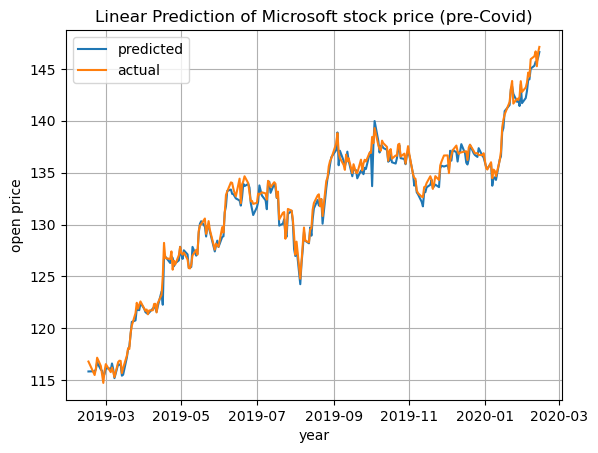

In [18]:
#pre-covid
lasso_model = Lasso(alpha=0.01)

lasso_model.fit(train_x_pre,train_y_pre)
predict_l_pre = lasso_model.predict(test_x_pre)

linear_rmse_pre = np.sqrt(mean_squared_error(test_y_pre,predict_l_pre))

print("RMSE: " + str(linear_rmse_pre))

fig, ax = plt.subplots()
ax.plot(test_x_pre.index, predict_l_pre, label = 'predicted')
ax.plot(test_x_pre.index, test_y_pre, label = 'actual')
ax.set(xlabel='year', ylabel='open price',
       title='Linear Prediction of Microsoft stock price (pre-Covid)')
plt.legend(loc = 'upper left')
ax.grid()
plt.show()

RMSE: 1.0819328140030677


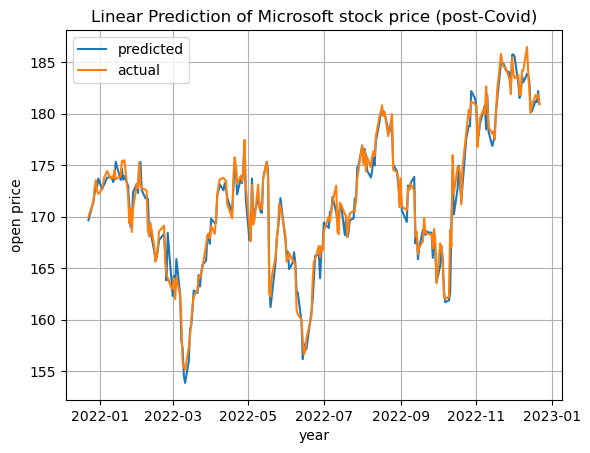

In [19]:
#post-covid
lasso_model.fit(train_x_post,train_y_post)
predict_l_post = lasso_model.predict(test_x_post)

linear_rmse_post = np.sqrt(mean_squared_error(test_y_post,predict_l_post))

print("RMSE: " + str(linear_rmse_post))

fig, ax = plt.subplots()
ax.plot(test_x_post.index, predict_l_post, label = 'predicted')
ax.plot(test_x_post.index, test_y_post, label = 'actual')
ax.set(xlabel='year', ylabel='open price',
       title='Linear Prediction of Microsoft stock price (post-Covid)')
plt.legend(loc = 'upper left')
ax.grid()
plt.show()

# <strong>Creating Regression Enhanced Random Forest Model<strong>

In [20]:
#creating residuals based off linear predictions
residuals_pre =  pd.DataFrame(test_y_pre.index).set_index(0)
residuals_post =  pd.DataFrame(test_y_post.index).set_index(0)

residuals_pre['residual'] = predict_l_pre - test_y_pre
residuals_post['residual'] = predict_l_post - test_y_post

residuals_pre_train = residuals_pre.head(int(0.8*(len(residuals_pre))))
residuals_pre_test = residuals_pre.tail(int(0.2*(len(residuals_pre))))

residuals_post_train = residuals_post.head(int(0.8*(len(residuals_post))))
residuals_post_test = residuals_post.tail(int(0.2*(len(residuals_post))))

residuals_pre_train.shape,residuals_pre_test.shape,residuals_post_train.shape,residuals_post_test.shape

((201, 1), (50, 1), (201, 1), (50, 1))

In [21]:
# creating train and test sets for forest model, pre-covid
train_rfx_pre = test_x_pre.head(int(0.8*(len(test_x_pre))))
test_rfx_pre = test_x_pre.tail(int(0.2*(len(test_x_pre))))

train_rfy_pre = test_y_pre.head(int(0.8*(len(test_y_pre))))
test_rfy_pre = test_y_pre.tail(int(0.2*(len(test_y_pre))))

train_rfx_pre.shape,test_rfx_pre.shape,train_rfy_pre.shape,test_rfy_pre.shape

((201, 50), (50, 50), (201,), (50,))

In [22]:
# creating train and test sets for forest model, post-covid
train_rfx_post = test_x_post.head(int(0.8*(len(test_x_post))))
test_rfx_post = test_x_post.tail(int(0.2*(len(test_x_post))))

train_rfy_post = test_y_post.head(int(0.8*(len(test_y_post))))
test_rfy_post = test_y_post.tail(int(0.2*(len(test_y_post))))

train_rfx_post.shape,test_rfx_post.shape,train_rfy_post.shape,test_rfy_post.shape

((201, 50), (50, 50), (201,), (50,))

In [23]:
#running random forest model on resiudals (pre-Covid)
forest_model = RandomForestRegressor(min_samples_leaf = 12)

forest_model.fit(train_rfx_pre,residuals_pre_train.values.ravel())
predict_rf_pre = forest_model.predict(test_rfx_pre)

In [24]:
#running random forest model on resiudals (post-Covid)
forest_model.fit(train_rfx_post,residuals_post_train.values.ravel())
predict_rf_post = forest_model.predict(test_rfx_post)

In [25]:
#preparing dataframes for baseline and prediction

base_l_pre = pd.DataFrame(test_x_pre.index).set_index(0)
base_l_pre['predict'] = predict_l_pre
base_l_test_pre = base_l_pre.tail(int(0.2*(len(base_l_pre))))

base_l_post = pd.DataFrame(test_x_post.index).set_index(0)
base_l_post['predict'] = predict_l_post
base_l_test_post = base_l_post.tail(int(0.2*(len(base_l_post))))

predict_rf_test_pre = pd.DataFrame(test_rfx_pre.index).set_index(0)
predict_rf_test_pre['predict'] = predict_rf_pre

predict_rf_test_post = pd.DataFrame(test_rfx_post.index).set_index(0)
predict_rf_test_post['predict'] = predict_rf_post

base_l_test_pre.shape, base_l_test_post.shape, predict_rf_test_pre.shape, predict_rf_test_post.shape

((50, 1), (50, 1), (50, 1), (50, 1))

RMSE: 0.6091236821055029


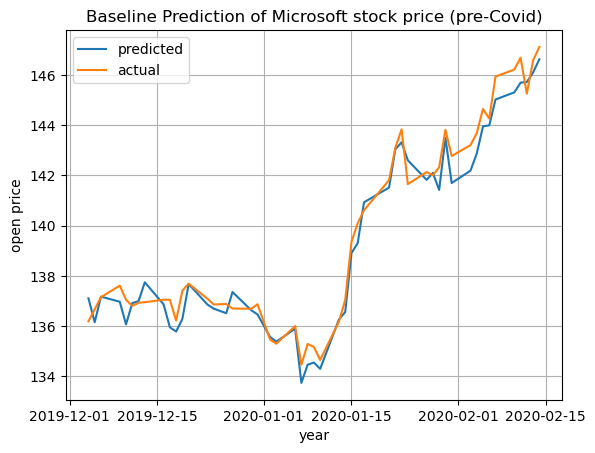

In [26]:
#RMSE of baseline predictions (pe-Covid)

rmse_pre = np.sqrt(mean_squared_error(test_rfy_pre,base_l_test_pre))

print("RMSE: " + str(rmse_pre))

fig, ax = plt.subplots()

ax.plot(test_rfy_pre.index,base_l_test_pre, label = 'predicted')
ax.plot(test_rfy_pre.index, test_rfy_pre, label = 'actual')
ax.set(xlabel='year', ylabel='open price',
       title='Baseline Prediction of Microsoft stock price (pre-Covid)')
plt.legend(loc = 'upper left')
ax.grid()
plt.show()

RMSE: 0.5278557427261839


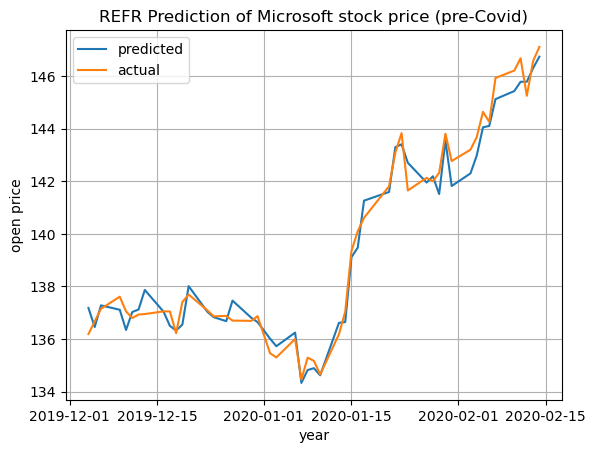

In [27]:
#subtracting predicted residue from baseline predicitons to derive predicted close prices (pre-Covid)
prediction_pre = pd.DataFrame(test_rfx_pre.index).set_index(0)
prediction_pre['prediction'] = base_l_test_pre - predict_rf_test_pre

rmse_pre = np.sqrt(mean_squared_error(test_rfy_pre,prediction_pre['prediction']))

print("RMSE: " + str(rmse_pre))

fig, ax = plt.subplots()
ax.plot(base_l_test_pre.index, prediction_pre['prediction'], label = 'predicted')
ax.plot(base_l_test_pre.index, test_rfy_pre, label = 'actual')
ax.set(xlabel='year', ylabel='open price',
       title='REFR Prediction of Microsoft stock price (pre-Covid)')
plt.legend(loc = 'upper left')
ax.grid()
plt.show()

RMSE: 1.1541850060133727


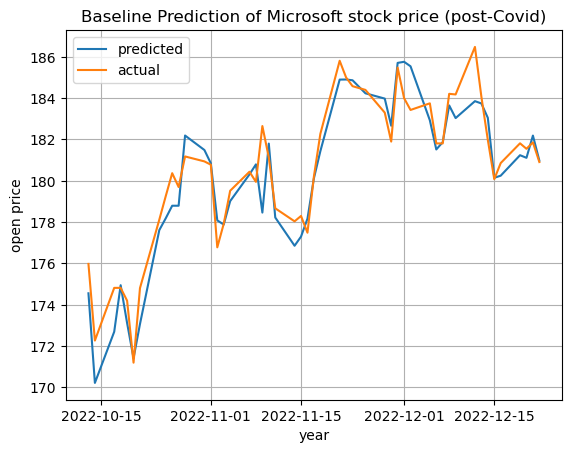

In [28]:
#RMSE of baseline predictions (post-Covid)

rmse_post = np.sqrt(mean_squared_error(test_rfy_post,base_l_test_post))

print("RMSE: " + str(rmse_post))

fig, ax = plt.subplots()
ax.plot(test_rfy_post.index,base_l_test_post, label = 'predicted')
ax.plot(test_rfy_post.index, test_rfy_post, label = 'actual')
ax.set(xlabel='year', ylabel='open price',
       title='Baseline Prediction of Microsoft stock price (post-Covid)')
plt.legend(loc = 'upper left')
ax.grid()
plt.show()

RMSE: 1.1441561637812332


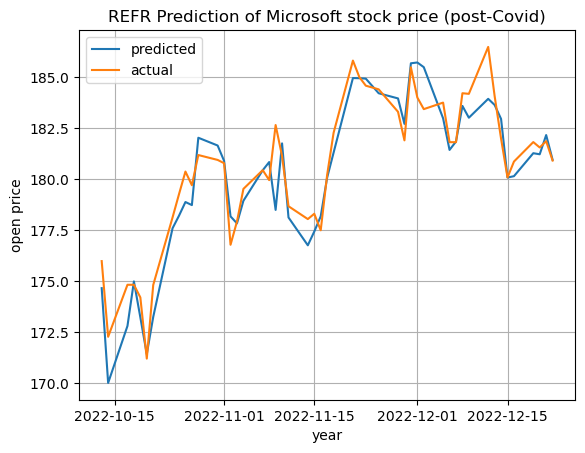

In [29]:
#subtracting predicted residue from linear predicitons to derive predicted close prices (post-Covid)
prediction_post = pd.DataFrame(test_rfx_post.index).set_index(0)
prediction_post['prediction'] = base_l_test_post - predict_rf_test_post

rmse_post = np.sqrt(mean_squared_error(test_rfy_post,prediction_post['prediction']))

print("RMSE: " + str(rmse_post))

fig, ax = plt.subplots()
ax.plot(base_l_test_post.index, prediction_post['prediction'], label = 'predicted')
ax.plot(base_l_test_post.index, test_rfy_post, label = 'actual')
ax.set(xlabel='year', ylabel='open price',
       title='REFR Prediction of Microsoft stock price (post-Covid)')
plt.legend(loc = 'upper left')
ax.grid()
plt.show()

In [30]:
#shifting back prediction to match dates for prediction
forecast_pre_na = pd.DataFrame(data = {'1. open': df_dates_pre['1. open'],'prediction_shift': prediction_pre['prediction']}, index = df_dates_pre.index)
forecast_pre_na['prediction'] = forecast_pre_na['prediction_shift'].shift(1)
forecast_pre = forecast_pre_na[forecast_pre_na['prediction'].notna()]

forecast_post_na = pd.DataFrame(data = {'1. open': df_dates_post['1. open'],'prediction_shift': prediction_post['prediction']}, index = df_dates_post.index)
forecast_post_na['prediction'] = forecast_post_na['prediction_shift'].shift(1)
forecast_post = forecast_post_na[forecast_post_na['prediction'].notna()]

# <strong>Implementing ML based trading strategy (pre-Covid)<strong>

/var/folders/gl/_7vxdj795rgcq3s4lj00kbk80000gp/T/ipykernel_15505/1903675163.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_pre['portfolio_ml'] = portfolio_ml_pre
/var/folders/gl/_7vxdj795rgcq3s4lj00kbk80000gp/T/ipykernel_15505/1903675163.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_pre['cash_ml'] = cash_list_ml_pre
/var/folders/gl/_7vxdj795rgcq3s4lj00kbk80000gp/T/ipykernel_15505/1903675163.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

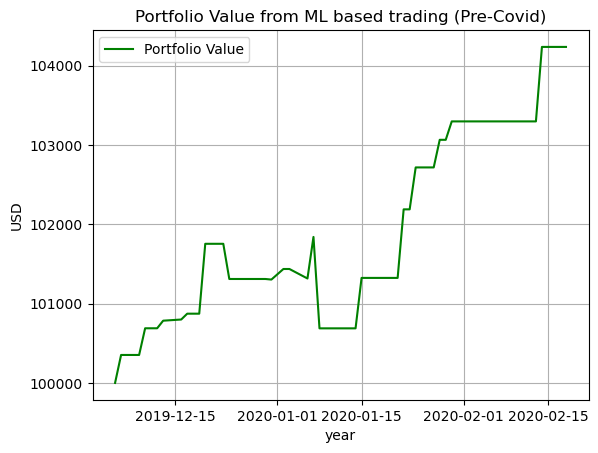

Total portfolio value: 104234.17


In [31]:
cash_ml_pre = 100000
shares_ml_pre = 0

portfolio_ml_pre = []
cash_list_ml_pre = []

for index, row in forecast_pre.iterrows():
    if row['prediction'] > row['1. open']: #buy signal
        if shares_ml_pre > 0: 
            #hold onto share
            portfolio_ml_pre.append(shares_ml_pre)
            cash_list_ml_pre.append(cash_ml_pre)
        elif shares_ml_pre <= 0:
            #buy shares here
            shares_ml_pre = int((cash_ml_pre / row['1. open']))
            cash_ml_pre = (cash_ml_pre - (shares_ml_pre * row['1. open']))
            portfolio_ml_pre.append(shares_ml_pre)
            cash_list_ml_pre.append(cash_ml_pre)
            
    elif row['prediction'] < row['1. open']: # sell signal
        if shares_ml_pre <= 0:
            #hold onto cash
            portfolio_ml_pre.append(shares_ml_pre)
            cash_list_ml_pre.append(cash_ml_pre)
        elif shares_ml_pre > 0:
            #sell shares here
            cash_ml_pre = cash_ml_pre + (shares_ml_pre * row['1. open'])
            shares_ml_pre = 0
            portfolio_ml_pre.append(shares_ml_pre)
            cash_list_ml_pre.append(cash_ml_pre)
            
forecast_pre['portfolio_ml'] = portfolio_ml_pre
forecast_pre['cash_ml'] = cash_list_ml_pre
forecast_pre['portfolio_value'] = (forecast_pre['portfolio_ml'] * forecast_pre['1. open']) + forecast_pre['cash_ml']

fig, ax = plt.subplots()
ax.plot(forecast_pre.index, forecast_pre['portfolio_value'], '-g', label = 'Portfolio Value')
ax.set(xlabel='year', ylabel='USD',
       title='Portfolio Value from ML based trading (Pre-Covid)')
plt.legend(loc = 'upper left')
ax.grid()
plt.show()

total_value_ml_pre = forecast_pre.iloc[-1,5]
print("Total portfolio value: " + str((round(total_value_ml_pre,2))))

# <strong>Implementing ML based trading strategy (post-Covid)<strong>

/var/folders/gl/_7vxdj795rgcq3s4lj00kbk80000gp/T/ipykernel_15505/437307334.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_post['portfolio_ml'] = portfolio_ml_post
/var/folders/gl/_7vxdj795rgcq3s4lj00kbk80000gp/T/ipykernel_15505/437307334.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_post['cash_ml'] = cash_list_ml_post
/var/folders/gl/_7vxdj795rgcq3s4lj00kbk80000gp/T/ipykernel_15505/437307334.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

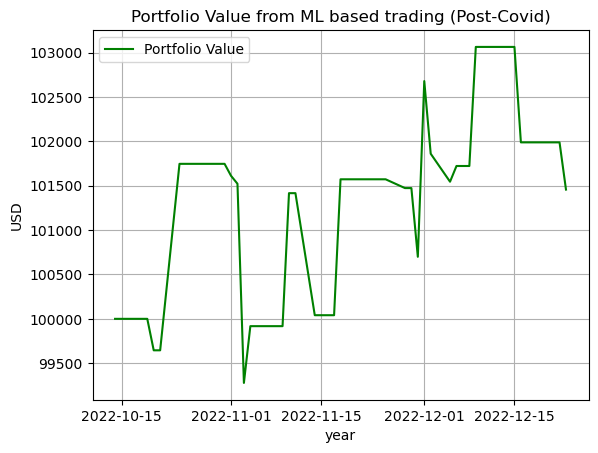

Total portfolio value: 101456.29


In [32]:
cash_ml_post = 100000
shares_ml_post = 0

portfolio_ml_post = []
cash_list_ml_post = []

for index, row in forecast_post.iterrows():
    if row['prediction'] > row['1. open']: #buy signal
        if shares_ml_post > 0: 
            #hold onto share
            portfolio_ml_post.append(shares_ml_post)
            cash_list_ml_post.append(cash_ml_post)
        elif shares_ml_post <= 0:
            #buy shares here
            shares_ml_post = int((cash_ml_post / row['1. open']))
            cash_ml_post = (cash_ml_post - (shares_ml_post * row['1. open']))
            portfolio_ml_post.append(shares_ml_post)
            cash_list_ml_post.append(cash_ml_post)
            
    elif row['prediction'] < row['1. open']: # sell signal
        if shares_ml_post <= 0:
            #hold onto cash
            portfolio_ml_post.append(shares_ml_post)
            cash_list_ml_post.append(cash_ml_post)
        elif shares_ml_post > 0:
            #sell shares here
            cash_ml_post = cash_ml_post + (shares_ml_post * row['1. open'])
            shares_ml_post = 0
            portfolio_ml_post.append(shares_ml_post)
            cash_list_ml_post.append(cash_ml_post)
            
forecast_post['portfolio_ml'] = portfolio_ml_post
forecast_post['cash_ml'] = cash_list_ml_post
forecast_post['portfolio_value'] = (forecast_post['portfolio_ml'] * forecast_post['1. open']) + forecast_post['cash_ml']

fig, ax = plt.subplots()
ax.plot(forecast_post.index, forecast_post['portfolio_value'], '-g', label = 'Portfolio Value')
ax.set(xlabel='year', ylabel='USD',
       title='Portfolio Value from ML based trading (Post-Covid)')
plt.legend(loc = 'upper left')
ax.grid()
plt.show()

total_value_ml_post = forecast_post.iloc[-1,5]
print("Total portfolio value: " + str((round(total_value_ml_post,2))))

# <strong>Conclusion</strong>
<strong>Portfolio value (USD) after 2 months</strong><br> 
<br>
SMA Crossover (pre-Covid): 103935.74 <br>
SMA Crossover (post-Covid): 103008.72 <br>
<br>
REFR based trading (pre-Covid): 104234.17 <br>
REFR based trading (post-Covid): 101179.52 <br>
<br>
<strong>RMSE comparison</strong><br>
<br>
linear model (pre-Covid): 0.609 <br>
linear model (post-Covid): 1.154 <br>
<br>
REFR model (pre-Covid): 0.537 <br>
REFR model (post-Covid): 1.144 <br>
<br>
In both pre and post-Covid environments, the RERF model improved the accuracy of the purely models marginally. The high REFR shows that while a purely linear model is not suited for predicting PEP stock post-Covid, the REFR model is successful in improving the accuracy of the predictions marginally. <br>
The effectiveness of the REFR model in pre-Covid environments can be seen by comparing REFR based trading against SMA crossover, whithe  <br>
    
This project can be improved with multi-variable models to enhance accuracy by analysing more factors which affect the stock market in diffeent environments, and it will be interesting to test the effectiveness of REFR applied onto multi-variable models. Further tuning of the model parameters are also required, and can be performed to improve the accuracy of the REFR model <br>
<br>
References: Zhang, H., Nettleton, D., & Zhu, Z. (2019). Regression-enhanced random forests. arXiv preprint arXiv:1904.10416.